In [1]:
import os
import logging, os

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import tensorflow as tf
import keras
from musicnet.preprocessing.wav_specs_and_notes.utils import create_tf_record_ds
from musicnet.models.transformer.Transformer import F1FromSeqLogits, WeightedBinaryCrossentropy, WarmupLRSchedule
from musicnet.utils import load_params, PROJECT_ROOT_DIR, notes_vocab, instruments_vocab, note_frequency
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from utils import y_vs_y_pred_vis, spectogram_vis
from ipywidgets import interact
import librosa
import pandas as pd
from tqdm import tqdm

2024-07-26 00:13:03.073236: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 00:13:03.073265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 00:13:03.073287: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
model = keras.models.load_model(
    os.path.join(PROJECT_ROOT_DIR, "musicnet", "models", "cnn", "model.keras"),
    {
        "WeightedBinaryCrossentropy": WeightedBinaryCrossentropy,
        "F1FromSeqLogits": F1FromSeqLogits,
        "WarmupLRSchedule": WarmupLRSchedule
    }
)

OSError: No file or directory found at /home/leszek/projects/musicnet/musicnet/models/cnn/model.keras

In [5]:
params = load_params([
    "cnn.*",
    "wav_specs_and_notes.preprocessor.target_sr",
    "wav_specs_and_notes.preprocessor.spectogram.*",
    "wav_specs_and_notes.use_converted_midis",
    "midi_to_wav.programs_whitelist"
])

In [6]:
if params["programs_whitelist"]:
    target_classes = len(notes_vocab) * len(params["programs_whitelist"])
else:
    target_classes = len(notes_vocab) * len(instruments_vocab)

In [7]:
ds_params = {
    "architecture": "cnn",
    "n_filters": params["n_filters"],
    "target_classes": target_classes,
    "batch_size": params["batch_size"],
    "dataset_size": params["dataset_size"],
    "use_converted_midis": params["use_converted_midis"]
}

In [8]:
train_ds = create_tf_record_ds("train", **ds_params)
val_ds = create_tf_record_ds("val", **ds_params, shuffle=False)

In [9]:
model.loss

In [10]:
model.compile(
    loss=model.loss,
    metrics=[
        F1FromSeqLogits(threshold=0.5, average="weighted", name="f1_weighted"),
        F1FromSeqLogits(threshold=0.5, average="micro", name="f1_global"),
        keras.metrics.Precision(0, name="precision"),
        keras.metrics.Precision(0, name="precision_33", class_id=33),
        keras.metrics.Recall(0, name="recall")
    ]
)

In [11]:
model.evaluate(val_ds)

322/322 [==============================] - 10s 25ms/step - loss: 2.1914 - f1_weighted: 0.3363 - f1_global: 0.3370 - precision: 0.2523 - precision_33: 0.2990 - recall: 0.5072


[2.1913740634918213,
 0.33625364303588867,
 0.33696943521499634,
 0.25230124592781067,
 0.2989988923072815,
 0.5071660876274109]

In [12]:
y_pred = model.predict(val_ds)
y_pred = tf.sigmoid(y_pred)

322/322 [==============================] - 7s 22ms/step


In [14]:
y_true = None
for x_batch, y_batch in val_ds:
    y_true = tf.concat((y_true, y_batch), axis=0) if y_true is not None else y_batch

In [15]:
print(y_pred.shape)
print(y_true.shape)

(2570, 1000, 83)
(2570, 1000, 83)


In [27]:
def calc_per_note_stats(y_true, y_pred, threshold=0.5):
    stats = []
    for i in tqdm(list(range(0, len(notes_vocab)))):
        precision = keras.metrics.Precision(threshold, class_id=i)(y_true, y_pred)
        recall = keras.metrics.Recall(threshold, class_id=i)(y_true, y_pred)
        true_count = tf.reduce_sum(y_true[:, :, i])
        pred_count = tf.reduce_sum(tf.cast(y_pred[:, :, i] > threshold, tf.float32))
        tp = tf.reduce_sum(
            tf.cast(
                ((y_pred[:, :, i] > threshold) & tf.cast(y_true[:, :, i], tf.bool)),
                tf.float32
            ))
        stats.append({
            "note_idx": i,
            "note_freq": note_frequency(i),
            "true_count": int(true_count.numpy()),
            "pred_count": int(pred_count.numpy()),
            "tp": int(tp.numpy()),
            "fp": int(pred_count.numpy()) - int(tp.numpy()),
            "fn": int(true_count.numpy()) - int(tp.numpy()),
            "precision": round(precision.numpy(), 3),
            "recall": round(recall.numpy(), 3)
        })
    return pd.DataFrame(stats)

def calc_per_batch_stats(y_true, y_pred, threshold=0.5, batch_size=128):
    stats = []
    for x in tqdm(list(range(batch_size, y_true.shape[0] + 1, batch_size))):
        y_true_batch = y_true[x-batch_size:x, :, :]
        y_pred_batch = y_pred[x-batch_size:x, :, :]
        precision = keras.metrics.Precision(threshold)(y_true_batch, y_pred_batch)
        recall = keras.metrics.Recall(threshold)(y_true_batch, y_pred_batch)
        true_count = tf.reduce_sum(y_true_batch)
        pred_count = tf.reduce_sum(tf.cast(y_pred_batch > threshold, tf.float32))
        tp = tf.reduce_sum(
            tf.cast(
                ((y_pred_batch > threshold) & tf.cast(y_true_batch, tf.bool)),
                tf.float32
            ))
        stats.append({
            "batch": x // batch_size,
            "true_count": int(true_count.numpy()),
            "pred_count": int(pred_count.numpy()),
            "tp": int(tp.numpy()),
            "fp": int(pred_count.numpy()) - int(tp.numpy()),
            "fn": int(true_count.numpy()) - int(tp.numpy()),
            "precision": round(precision.numpy(), 3),
            "recall": round(recall.numpy(), 3)
        })
    return pd.DataFrame(stats)

In [28]:
per_note_stats = calc_per_note_stats(y_true, y_pred)
pd.set_option("display.max_rows", 100)
per_note_stats

100%|██████████| 83/83 [00:01<00:00, 63.66it/s]


,note_idx,note_freq,true_count,pred_count,tp,fp,fn,precision,recall
0,0,27.500000,0,0,0,0,0,0.000,0.000
1,1,30.867706,0,0,0,0,0,0.000,0.000
2,2,32.703196,178,86,0,86,178,0.000,0.000
3,3,34.647829,120,103,0,103,120,0.000,0.000
4,4,36.708096,2596,2156,994,1162,1602,0.461,0.383
5,5,38.890873,6965,2554,495,2059,6470,0.194,0.071
6,6,41.203445,3416,3620,1766,1854,1650,0.488,0.517
7,7,43.653529,18074,14953,6413,8540,11661,0.429,0.355
8,8,46.249303,8690,11797,4039,7758,4651,0.342,0.465
9,9,48.999429,36362,57831,20751,37080,15611,0.359,0.571


In [29]:
per_batch_stats = calc_per_batch_stats(y_true, y_pred, batch_size=128)
pd.set_option("display.max_rows", 100)
per_batch_stats

100%|██████████| 20/20 [00:00<00:00, 67.88it/s]


,batch,true_count,pred_count,tp,fp,fn,precision,recall
0,1,318077,620976,146895,474081,171182,0.237,0.462
1,2,285620,630337,125158,505179,160462,0.199,0.438
2,3,293365,588159,97042,491117,196323,0.165,0.331
3,4,291120,592284,82362,509922,208758,0.139,0.283
4,5,279064,638181,93812,544369,185252,0.147,0.336
5,6,320673,596961,114704,482257,205969,0.192,0.358
6,7,291257,606677,116769,489908,174488,0.192,0.401
7,8,303420,661562,134988,526574,168432,0.204,0.445
8,9,318569,599194,124975,474219,193594,0.209,0.392
9,10,308184,608458,137213,471245,170971,0.226,0.445


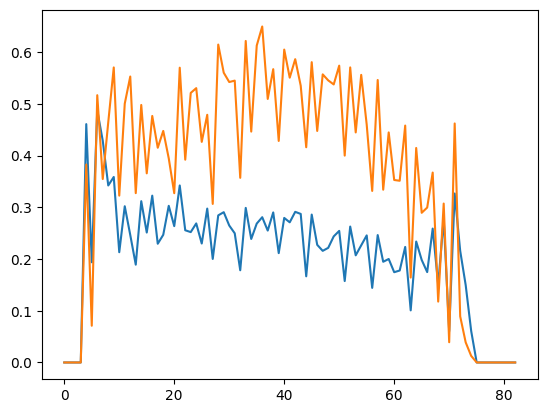

In [18]:
plt.plot(per_note_stats["precision"])
plt.plot(per_note_stats["recall"])

In [41]:
for x, y in val_ds:
    break

In [42]:
print(x.shape, y.shape)

(8, 1000, 200) (8, 1000, 83)


In [43]:
y_pred = model(x)
y_pred = tf.sigmoid(y_pred)

In [50]:
spectogram_params = { k: v for k, v in params.items() if k in ["n_fft", "target_sr", "min_hz"] }

@interact(i=(0, params["batch_size"] - 1), t=(0.5, 1.0))
def show_sample(i, t=0.5):
    y_vs_y_pred_vis(y[i].numpy(), (y_pred > t)[i].numpy())
    spectogram_vis(x[i].numpy(), **spectogram_params)

interactive(children=(IntSlider(value=3, description='i', max=7), FloatSlider(value=0.5, description='t', max=…

In [217]:
# @tf.function
# def run_inference(context, max_len=999, head_start=0):
#     y_pred = tf.TensorArray(dtype=tf.bool, size=0, dynamic_size=True)
#     for i in tf.range(head_start):
#         y_pred = y_pred.write(i, y[-1, i, :])
#     for i in tf.range(head_start, max_len):
#         next_pred = model([context, [y_pred.stack()]], training=False)[-1, -1, :]
#         next_pred = tf.sigmoid(next_pred)
#         y_pred = y_pred.write(i, next_pred > 0.5)
#     return y_pred.stack()

In [251]:
# y_pred_infer = run_inference(context, y.shape[1], head_start=100)
# y_pred_context = model([context, x])[0]
# y_pred_context = tf.sigmoid(y_pred_context).numpy() > 0.5